In [1]:
%pip -q install sentence-transformers umap-learn pandas openpyxl matplotlib

In [3]:
import re, os, zipfile, urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
sbert = SentenceTransformer(MODEL_NAME)

TOKEN_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def normalize(text: str):
    toks = [t.lower() for t in TOKEN_RE.findall(str(text))]
    return " ".join([t for t in toks if len(t) > 2])

def embed_texts(texts):
    # trả về ndarray (N, D)
    return sbert.encode(texts, normalize_embeddings=False, convert_to_numpy=True)

def cos_sim_matrix(A, B):
    # cosine similarity giữa hai ma trận vector
    return cosine_similarity(A, B)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
import kagglehub
from pathlib import Path

kh_path = kagglehub.dataset_download("samantas2020/online-retail-xlsx")
DATA_DIR = Path(kh_path)
print("DATA_DIR:", DATA_DIR)

cands = list(DATA_DIR.rglob("*.xlsx"))
assert cands, "Không tìm thấy file .xlsx trong thư mục kagglehub."
pref = [p for p in cands if "online" in p.name.lower()]
xlsx_path = pref[0] if pref else cands[0]

print("Using XLSX:", xlsx_path)

Using Colab cache for faster access to the 'online-retail-xlsx' dataset.
DATA_DIR: /kaggle/input/online-retail-xlsx
Using XLSX: /kaggle/input/online-retail-xlsx/Online Retail.xlsx


In [7]:
df = pd.read_excel(xlsx_path)

cols = ["InvoiceNo","StockCode","Description","Quantity","InvoiceDate","UnitPrice","CustomerID","Country"]
df = df[cols].copy()

df = df.dropna(subset=["InvoiceNo","StockCode","Description","InvoiceDate"])
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
df = df[(df["Quantity"]>0) & (df["UnitPrice"]>0)]
df["Description"] = df["Description"].astype(str).str.strip().str.lower()
df = df.sort_values(["InvoiceDate","InvoiceNo"]).reset_index(drop=True)

invoices = df["InvoiceNo"].drop_duplicates().tolist()
cut = int(0.9 * len(invoices))
train_invoices = set(invoices[:cut])
test_invoices  = set(invoices[cut:])

train_df = df[df["InvoiceNo"].isin(train_invoices)].copy()
test_df  = df[df["InvoiceNo"].isin(test_invoices)].copy()

print("Train rows:", len(train_df), "| Test rows:", len(test_df))


Train rows: 468276 | Test rows: 61828


In [8]:
prod_train = (train_df.groupby(["StockCode","Description"])
                        .size()
                        .reset_index(name="freq"))

prod_train["desc_norm"] = prod_train["Description"].apply(normalize)

# encode mô tả → vector (N, D)
V = embed_texts(prod_train["desc_norm"].tolist())

Vn = V / (np.linalg.norm(V, axis=1, keepdims=True) + 1e-9)

print("Product vocab:", len(prod_train), "| dim:", V.shape[1])
prod_train.head(3)

Product vocab: 4128 | dim: 384


,StockCode,Description,freq,desc_norm
0,10002,inflatable political globe,71,inflatable political globe
1,10080,groovy cactus inflatable,19,groovy cactus inflatable
2,10120,doggy rubber,26,doggy rubber


In [9]:
from numpy import argsort


code2idx = {c:i for i,c in enumerate(prod_train["StockCode"].tolist())}

def topn_similar_by_code(code: str, topn=10):
    if code not in code2idx: return []
    i = code2idx[code]
    sims = (Vn @ Vn[i]).astype(float)
    idx = argsort(-sims)
    out=[]
    for j in idx:
        if j==i: continue
        out.append((prod_train.iloc[j]["StockCode"], float(sims[j])))
        if len(out)==topn: break
    return out

def recommend_from_basket(codes, topn=10):
    idxs = [code2idx[c] for c in codes if c in code2idx]
    if not idxs: return []
    basket_vec = Vn[idxs].mean(axis=0)      # trung bình vector đã chuẩn hoá
    sims = (Vn @ basket_vec).astype(float)
    idx_sorted = argsort(-sims)
    seen = set(idxs)
    out=[]
    for j in idx_sorted:
        if j in seen: continue
        out.append((prod_train.iloc[j]["StockCode"], float(sims[j])))
        if len(out)==topn: break
    return out


In [10]:
popular = train_df["StockCode"].value_counts().index[:20].tolist()

query = popular[0]
print("Query item:", query)
topn_similar_by_code(query, topn=10)


Query item: 85123A


[('85123a', 1.0000001192092896),
 (22804, 0.915527880191803),
 (21733, 0.8935950994491577),
 (85118, 0.8585429191589355),
 (21814, 0.8585428595542908),
 (35968, 0.8191291093826294),
 (21313, 0.8040755987167358),
 ('84970S', 0.8032623529434204),
 ('84970s', 0.8032623529434204),
 (84978, 0.7992751598358154)]

In [11]:
basket = popular[:3]
print("Basket:", basket)
recommend_from_basket(basket, topn=10)


Basket: ['85123A', '85099B', 22423]


[('85123a', 0.4512518644332886),
 (21733, 0.44564640522003174),
 (23582, 0.4432605803012848),
 (22804, 0.44215506315231323),
 (21843, 0.43781793117523193),
 (21217, 0.4290149211883545),
 (23203, 0.4192997217178345),
 (71038, 0.41730526089668274),
 (21155, 0.4172930121421814),
 (20665, 0.40722471475601196)]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


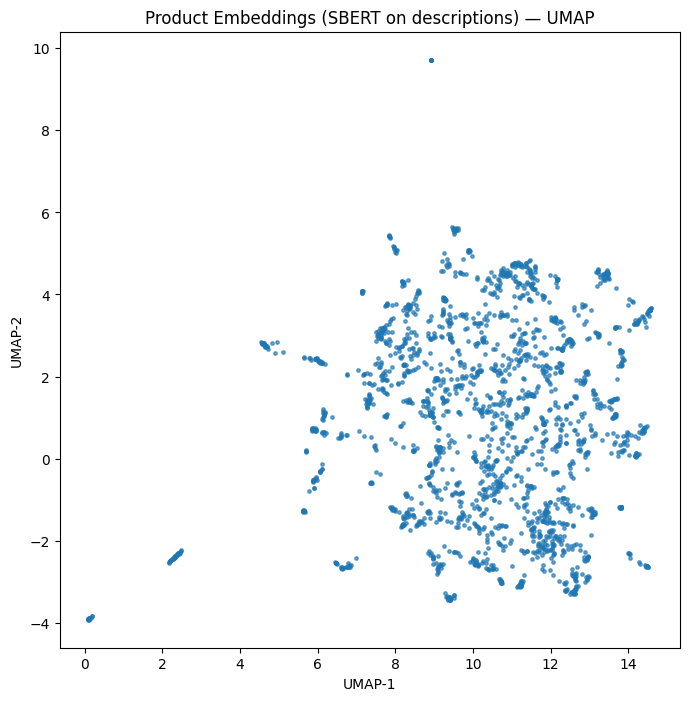

In [12]:
import umap, matplotlib.pyplot as plt

# lấy ~2000 sản phẩm phổ biến để vẽ
top_codes = train_df["StockCode"].value_counts().index[:2000]
mask = prod_train["StockCode"].isin(top_codes)
codes = prod_train[mask]["StockCode"].tolist()
X = Vn[mask.values]

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
X2 = reducer.fit_transform(X)

plt.figure(figsize=(8,8))
plt.scatter(X2[:,0], X2[:,1], s=6, alpha=0.65)
plt.title("Product Embeddings (SBERT on descriptions) — UMAP")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.show()
